# Synthetic data test: Sensitivity to interfering sources

The main goal of this synthetic is to show that the method works better than other Euler methods when there is interference from other sources in the data window.

In [1]:
from pathlib import Path
import numpy as np
from IPython.display import Image
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler
import warnings

In [2]:
warnings.filterwarnings("ignore")

## Create a model and data

Make a model from a dipole and add a base level and random noise.

Number of data: 12726


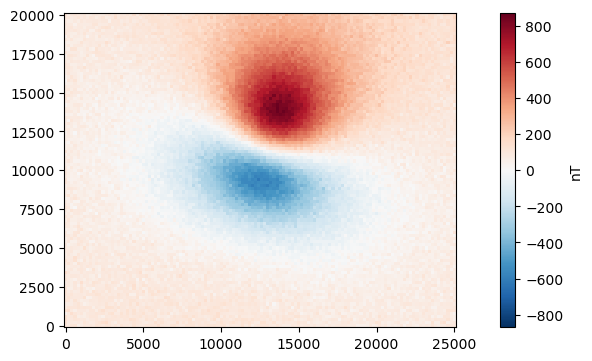

In [3]:
region = [0, 25e3, 0, 20e3]
height = 800
spacing = 200
coordinates = vd.grid_coordinates(region, spacing=spacing, extra_coords=height)
intensity, inclination, declination = 1e12, -30, 15
true_coordinates = (13e3, 11e3, -4e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=true_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(intensity, inclination, declination),
    field="b",
)
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))

# Add noise and the base level
noise_level = 20  # nT
magnetic_anomaly += np.random.default_rng(42).normal(
    0, noise_level, size=magnetic_anomaly.shape
)
base_level = 100  # nT
magnetic_anomaly += base_level

print(f"Number of data: {magnetic_anomaly.size}")

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5), layout="constrained")
ax.set_aspect("equal")
scale = vd.maxabs(magnetic_anomaly)
tmp = ax.pcolormesh(
    *coordinates[:2], magnetic_anomaly, cmap="RdBu_r", vmin=-scale, vmax=scale
)
fig.colorbar(tmp, label="nT")
plt.show()

Create 4 datasets from this with different interfering sources.

In [4]:
datasets_raw = []

magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=(1e3, 2e3, -8e3),
    magnetic_moments=hm.magnetic_angles_to_vec(4e12, inclination, declination),
    field="b",
)
datasets_raw.append(
    magnetic_anomaly + sum(b * f for b, f in zip(magnetic_field, main_field))
)

magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=(5e3, 16e3, -9e3),
    magnetic_moments=hm.magnetic_angles_to_vec(6e12, -10, -30),
    field="b",
)
datasets_raw.append(
    magnetic_anomaly + sum(b * f for b, f in zip(magnetic_field, main_field))
)

magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=(10e3, 14e3, -0.5e3),
    magnetic_moments=hm.magnetic_angles_to_vec(1.5e10, inclination, declination),
    field="b",
)
datasets_raw.append(
    magnetic_anomaly + sum(b * f for b, f in zip(magnetic_field, main_field))
)

magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=(20e3, 2.5e3, -0.5e3),
    magnetic_moments=hm.magnetic_angles_to_vec(2e10, inclination, declination),
    field="b",
)
datasets_raw.append(
    magnetic_anomaly + sum(b * f for b, f in zip(magnetic_field, main_field))
)

Now we can make an `xarray.Dataset` for the grid and calculate the first-order derivatives.

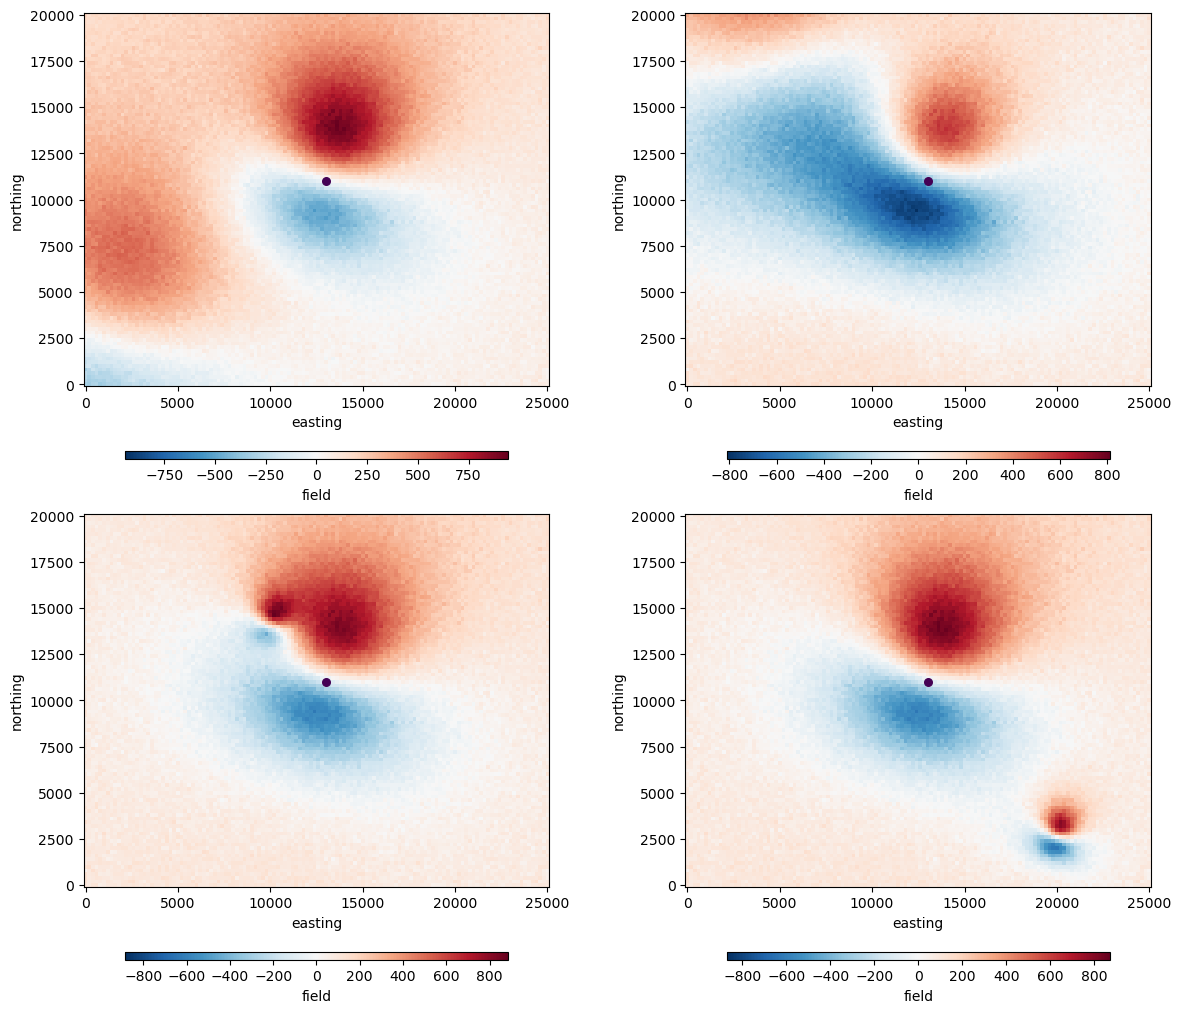

In [5]:
datasets = []
for raw in datasets_raw:
    data = vd.make_xarray_grid(
        coordinates[:2], (raw, coordinates[-1]), data_names=["field", "height"]
    )
    pad_width = {
        "easting": data.easting.size // 2,
        "northing": data.northing.size // 2,
    }
    data["deriv_east"] = hm.derivative_easting(data.field)
    data["deriv_north"] = hm.derivative_northing(data.field)
    data["deriv_up"] = xrft.unpad(
        hm.derivative_upward(
            xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
        ),
        pad_width,
    )
    data = data.assign_coords(height=data.height)
    datasets.append(data)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), layout="constrained")
for data, ax in zip(datasets, axes.ravel()):
    data.field.plot.pcolormesh(
        ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50, shrink=0.7)
    )
    ax.set_aspect("equal")
    tmp = ax.scatter(*true_coordinates[:2], c=true_coordinates[2], s=30)
plt.show()

## Run the Euler methods

Run Euler deconvolution, finite-difference Euler deconvolution [(Gerovska et al., 2005)](https://doi.org/10.1007/s00024-004-2623-1), and Euler inversion on a single data window. For Euler deconvolution, use the correct structural index of 3.

In [6]:
def euler_inversion_si_estimate(data):
    """
    Run Euler inversion with different SI and estimate the best one.
    """
    estimates = []
    for si in euler.STRUCTURAL_INDICES:
        estimates.append(euler.EulerInversion(structural_index=si).fit_grid(data))
    rmse = [ei.data_misfit_[-1] for ei in estimates]
    return estimates[np.argmin(rmse)]


deconv = [
    euler.EulerDeconvolution(structural_index=3).fit_grid(data) for data in datasets
]
deconvfd = [euler.EulerDeconvolutionFD().fit_grid(data) for data in datasets]
inversion = [euler_inversion_si_estimate(data) for data in datasets]

## Make a figure for the paper

Show the observed data and the estimates from all methods.

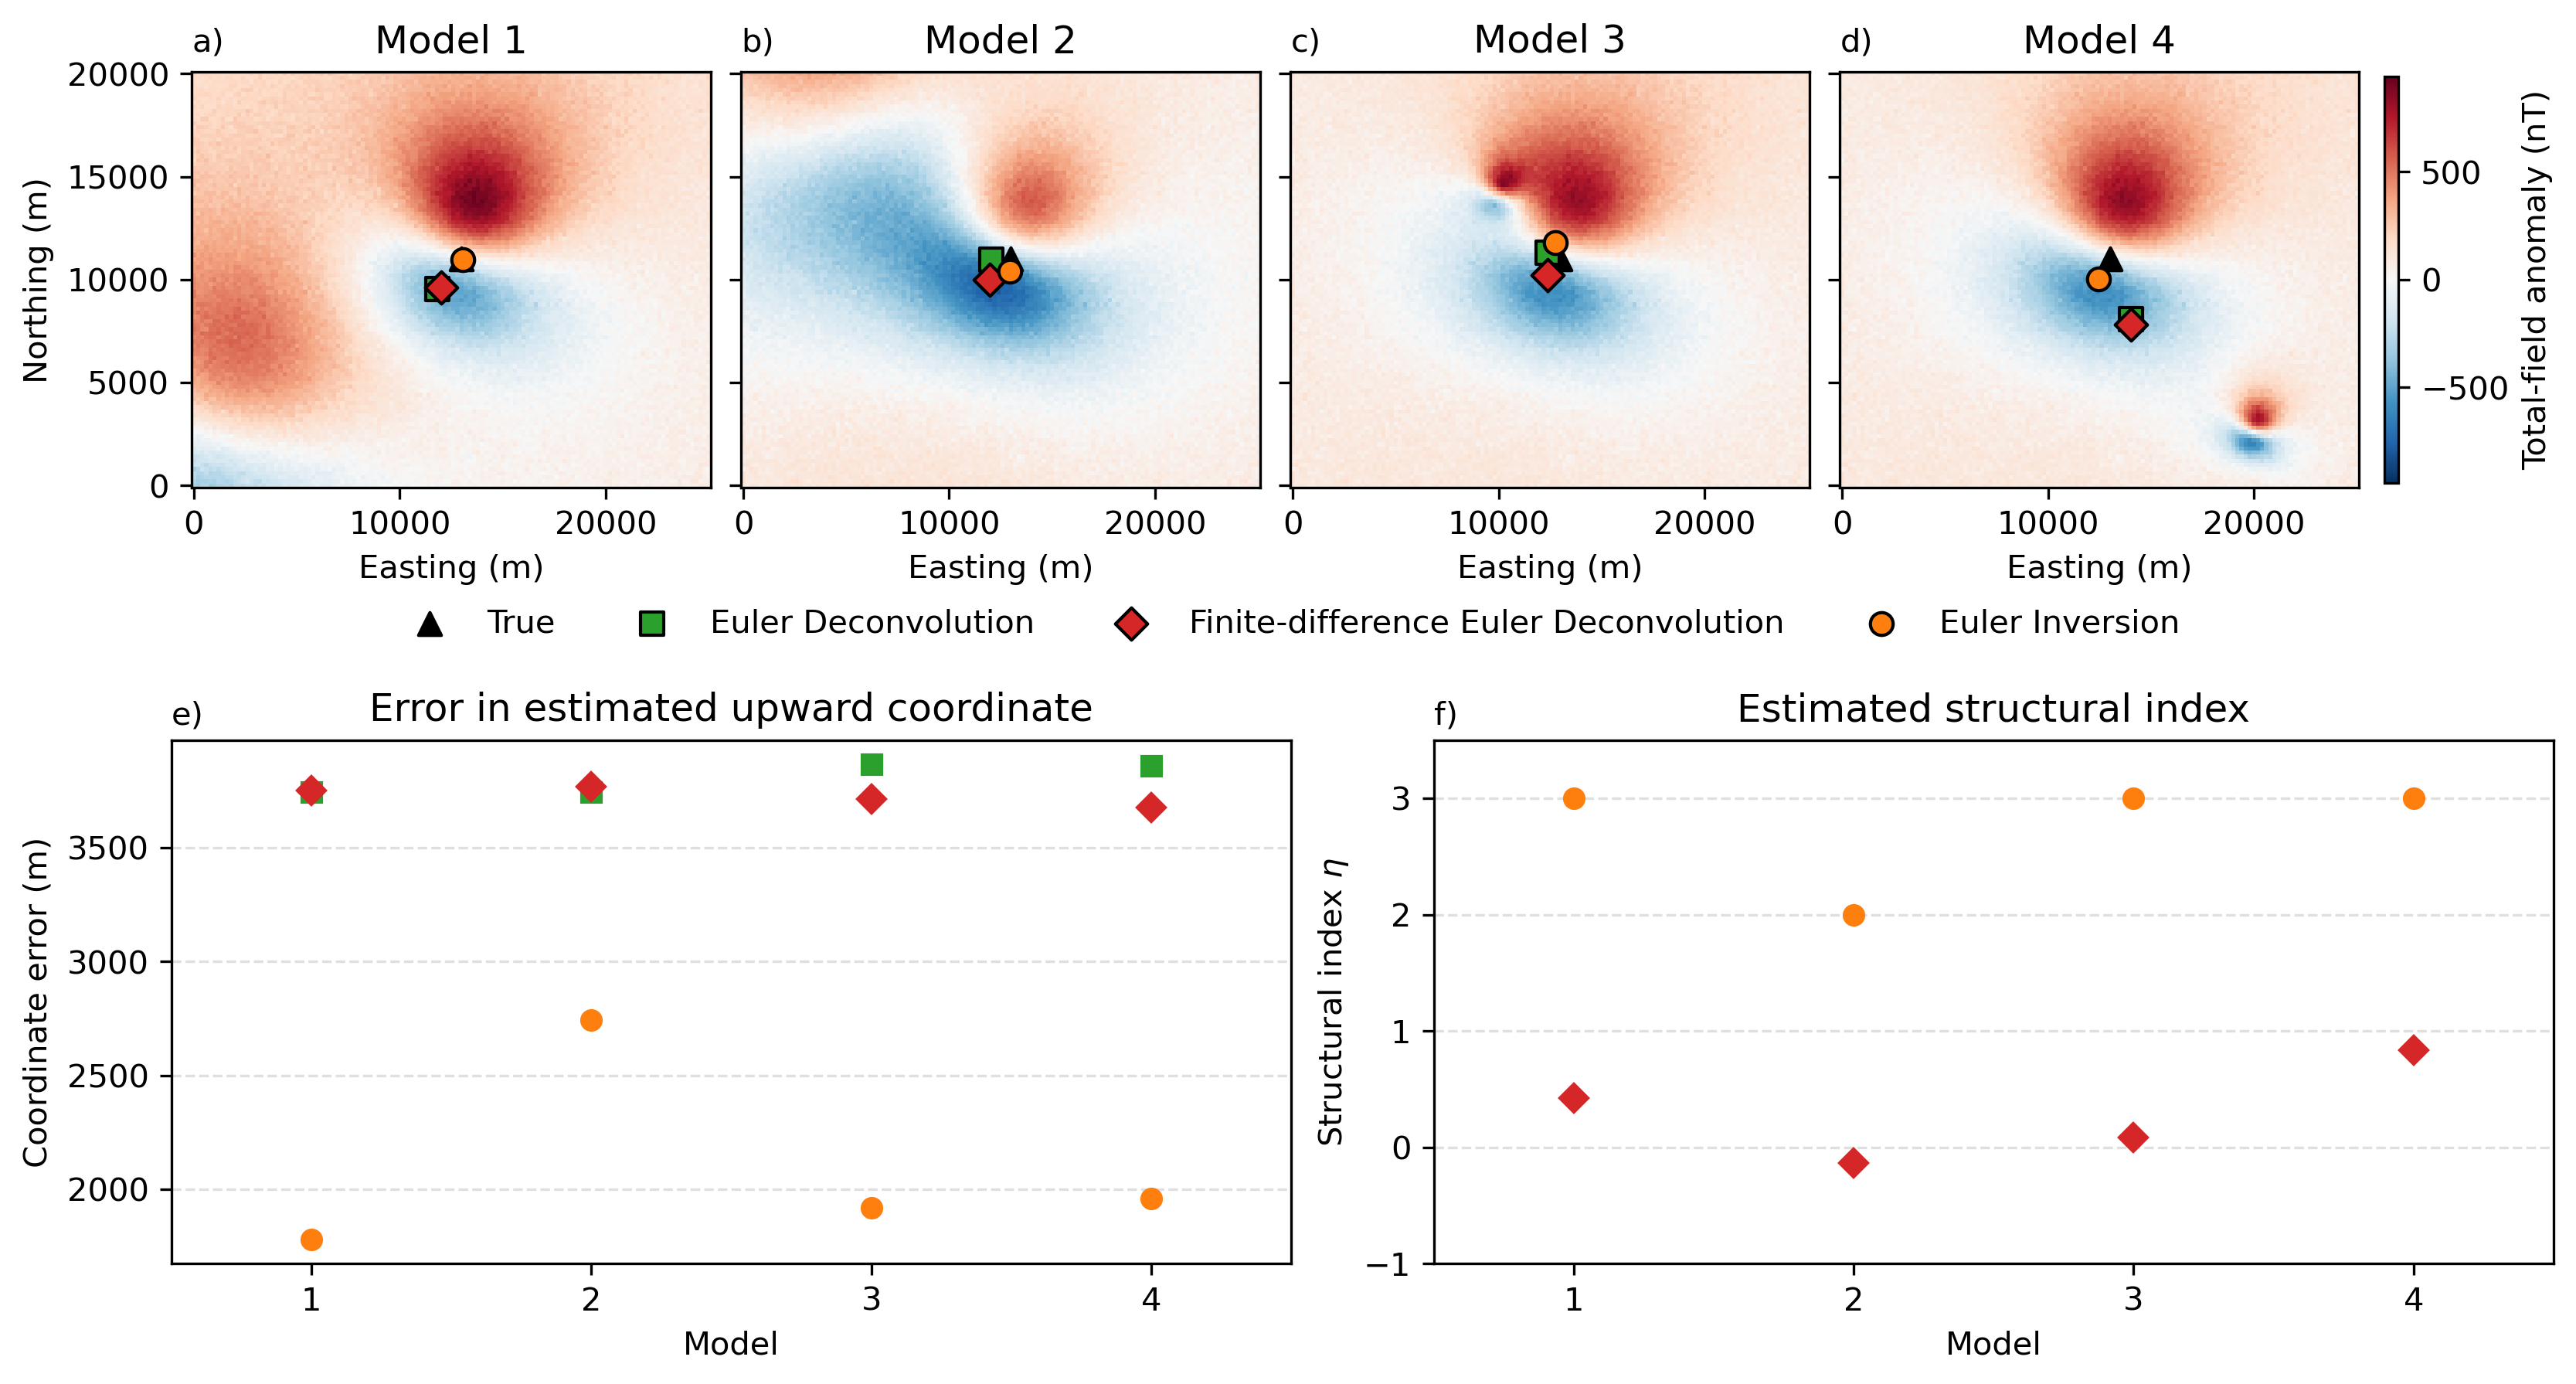

In [7]:
fig = plt.figure(figsize=(11, 6), layout="constrained")
figures = fig.subfigures(2, 1, height_ratios=[1, 1])

colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
marker_ei = "o"
color_ei = colors[1]
marker_ed = "s"
color_ed = colors[2]
marker_fd = "D"
color_fd = colors[3]

axes = figures[0].subplots(1, 4, sharey=True)

marker_size = 50
cbkwargs = dict()
scale = vd.maxabs([data.field for data in datasets])
for i, (data, ax, label) in enumerate(zip(datasets, axes.ravel(), "abcd")):
    ax.set_aspect("equal")
    ax.text(0, 1.05, f"{label})", transform=ax.transAxes)
    ax.set_title(f"Model {i + 1}")
    tmp = data.field.plot.pcolormesh(
        ax=ax,
        add_labels=False,
        add_colorbar=False,
        cmap="RdBu_r",
        vmin=-scale,
        vmax=scale,
    )
    label_true = ax.scatter(
        *true_coordinates[:2],
        c="k",
        s=marker_size,
        marker="^",
        linewidths=1,
        edgecolors="black",
    )
    label_ed = ax.scatter(
        *deconv[i].location_[:2],
        c=color_ed,
        s=marker_size,
        marker=marker_ed,
        linewidths=1,
        edgecolors="black",
    )
    label_fd = ax.scatter(
        *deconvfd[i].location_[:2],
        c=color_fd,
        s=marker_size,
        marker=marker_fd,
        linewidths=1,
        edgecolors="black",
    )
    label_ei = ax.scatter(
        *inversion[i].location_[:2],
        c=color_ei,
        s=marker_size,
        marker=marker_ei,
        linewidths=1,
        edgecolors="black",
    )
    ax.set_xlabel("Easting (m)")
axes[0].set_ylabel("Northing (m)")
fig.colorbar(tmp, ax=axes[-1], label="Total-field anomaly (nT)", aspect=30, shrink=0.7)
figures[0].legend(
    [label_true, label_ed, label_fd, label_ei],
    [
        "True",
        "Euler Deconvolution",
        "Finite-difference Euler Deconvolution",
        "Euler Inversion",
    ],
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    loc="outside lower center",
    ncols=4,
)
axes = figures[1].subplots(1, 2)
for ax, label in zip(axes, "ef"):
    ax.text(0, 1.03, f"{label})", transform=ax.transAxes)
    ax.grid(axis="y", alpha=0.4, linestyle="--")
    ax.set_xlabel("Model")
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xlim(0.5, 4.5)

ax = axes[0]
ax.set_title("Error in estimated upward coordinate")
ax.set_ylabel("Coordinate error (m)")
ax.plot(
    range(1, 5),
    [abs(true_coordinates[2] - e.location_[2]) for e in deconv],
    marker=marker_ed,
    color=color_ed,
    linestyle="",
)
ax.plot(
    range(1, 5),
    [abs(true_coordinates[2] - e.location_[2]) for e in deconvfd],
    marker=marker_fd,
    color=color_fd,
    linestyle="",
)
ax.plot(
    range(1, 5),
    [abs(true_coordinates[2] - e.location_[2]) for e in inversion],
    marker=marker_ei,
    color=color_ei,
    linestyle="",
)

ax = axes[1]
ax.set_title("Estimated structural index")
ax.set_ylabel("Structural index $\\eta$")
ax.plot(
    range(1, 5),
    [e.structural_index_ for e in deconvfd],
    marker=marker_fd,
    color=color_fd,
    linestyle="",
)
ax.plot(
    range(1, 5),
    [e.structural_index for e in inversion],
    marker=marker_ei,
    color=color_ei,
    linestyle="",
)
ax.set_ylim(-1, 3.5)

# Save the figure and display the saved figure because savefig and
# show can sometimes create slightly different figures
figfile = Path("..") / "paper" / "figures" / "synthetic-interfering-sources.png"
fig.savefig(figfile, dpi=300, bbox_inches="tight")
plt.close()
Image(figfile)

## Export a LaTeX file with information for the manuscript

Save things we want to include on the paper so that they can be referenced instead of copied.

In [8]:
output = rf"""
\newcommand{{\SynInterfTrueEast}}{{\qty{{{true_coordinates[0]:.0f}}}{{\m}}}}
\newcommand{{\SynInterfTrueNorth}}{{\qty{{{true_coordinates[1]:.0f}}}{{\m}}}}
\newcommand{{\SynInterfTrueUp}}{{\qty{{{true_coordinates[2]:.0f}}}{{\m}}}}
\newcommand{{\SynInterfTrueBase}}{{\qty{{{base_level:.0f}}}{{\nano\tesla}}}}
\newcommand{{\SynInterfInt}}{{\qty{{{intensity:.0e}}}{{\ampere\per\meter}}}}
\newcommand{{\SynInterfDec}}{{\qty{{{declination:.0f}}}{{\degree}}}}
\newcommand{{\SynInterfInc}}{{\qty{{{inclination:.0f}}}{{\degree}}}}
\newcommand{{\SynInterfNoise}}{{\qty{{{noise_level:.0f}}}{{\nano\tesla}}}}
\newcommand{{\SynInterfHeight}}{{\qty{{{height:.0f}}}{{\m}}}}
\newcommand{{\SynInterfSpacing}}{{\qty{{{spacing:.0f}}}{{\m}}}}
""".strip()
path = Path("..") / "paper" / "variables" / "synthetic-interfering-sources.tex"
path.write_text(output)
print(output)

\newcommand{\SynInterfTrueEast}{\qty{13000}{\m}}
\newcommand{\SynInterfTrueNorth}{\qty{11000}{\m}}
\newcommand{\SynInterfTrueUp}{\qty{-4000}{\m}}
\newcommand{\SynInterfTrueBase}{\qty{100}{\nano\tesla}}
\newcommand{\SynInterfInt}{\qty{1e+12}{\ampere\per\meter}}
\newcommand{\SynInterfDec}{\qty{15}{\degree}}
\newcommand{\SynInterfInc}{\qty{-30}{\degree}}
\newcommand{\SynInterfNoise}{\qty{20}{\nano\tesla}}
\newcommand{\SynInterfHeight}{\qty{800}{\m}}
\newcommand{\SynInterfSpacing}{\qty{200}{\m}}
